# Intro

OpenAI's CLIP (Contrastive Language-Image Pretraining) model is a machine learning model designed to understand and generate meaningful representations of images and text. It is trained on a large dataset of images and their associated textual descriptions, learning to associate images with their corresponding text.
The key innovation in CLIP is its use of contrastive learning, which involves training the model to recognize the correct pairing of an image and its description among a set of incorrect pairings. This approach enables the model to learn a wide range of visual concepts and their textual representations, making it capable of performing various tasks, such as image classification, object detection, and zero-shot learning.
CLIP's ability to understand both images and text allows it to be used in a variety of applications, including image search, content moderation, and generating image captions. Its versatility and performance have made it a popular choice for researchers and developers working on computer vision and natural language processing tasks.

In this notebook we are going to use a pretrained CLIP model for zero-shot object detection.

# Imports

In [1]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nxzvziga
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nxzvziga
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [2]:
import clip
import torch
import requests
import numpy as np
import torchvision
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

# Data

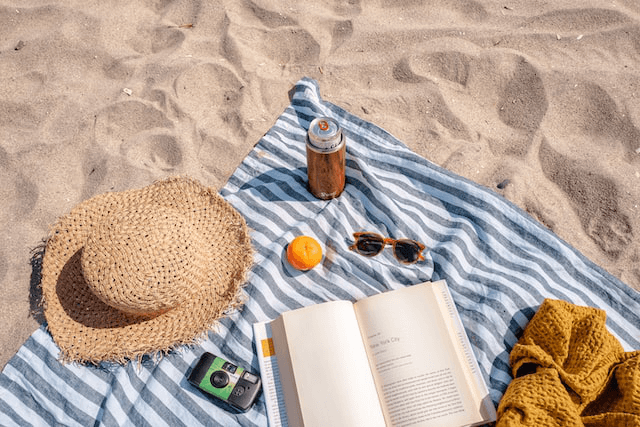

In [3]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")
img

# Extracting candidate regions

For this part use the RegionProposalNetwork in a pretrained faster rcnn to extract some candidate regions of different objects. Then visualize all the bounding boxes. You should get an image like this:

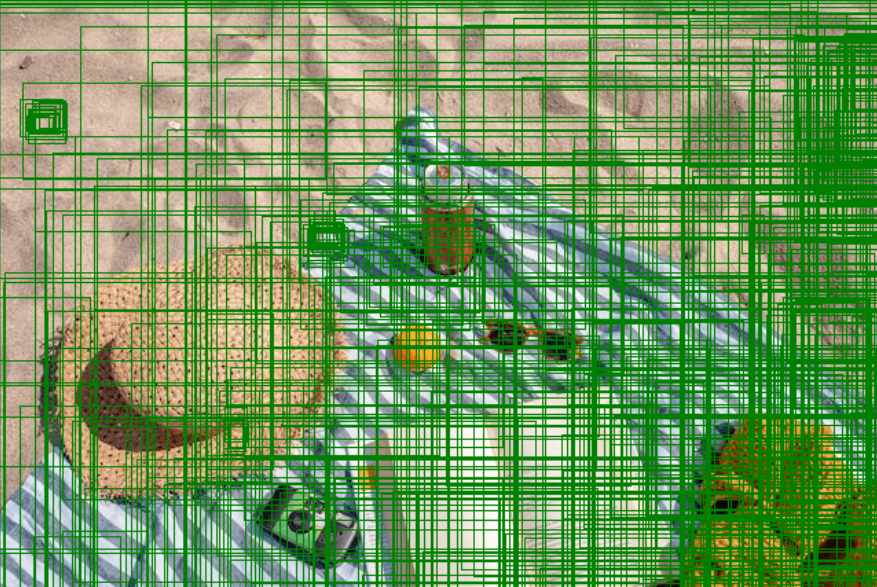

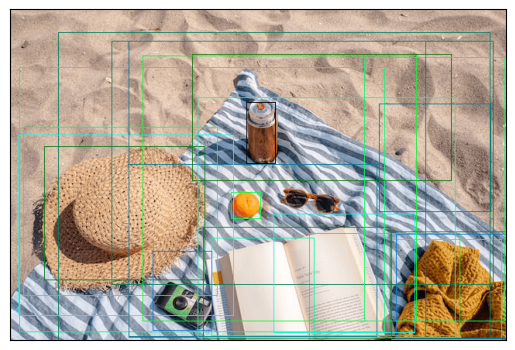

In [4]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")

faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
faster_rcnn.eval()

# =========================== BEGIN ===========================
image_float = torchvision.transforms.functional.to_tensor(img)   # floating type (in range [0, 1])

transform = transforms.Compose([transforms.PILToTensor()])
image_unit8 = transform(img)                                      # torch.uint8

#--------------------------------------------------------------
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
#------------------------------------------------------------

output = faster_rcnn([image_float])

#------------------------------------------------------------

boxes = output[0]['boxes']
result = draw_bounding_boxes(image_unit8, boxes)
show(result)
# =========================== END ===========================

# Object Detection

Now extract the CLIP representation of candidate regions and query text. In order to get better results you need to use an ensemble of prompts for your query. For each query write multiple similar prompts like the given example. Average the embedding of all prompts to get a representation of your query and then compute the cosine similarity between the query and region candidates and return the most likely. Do this for all the queries specified below and save the results in the notebook.

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [40]:
candidates = []
for box in boxes:
    candidates.append(img.crop((int(n) for n in box)))

In [47]:
def best_match(query, candidates):

    similarities = []

    for candidate in candidates :

        image_input = preprocess(candidate).unsqueeze(0).to(device)
        text_inputs = torch.cat([clip.tokenize(q) for q in query]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = torch.mean(model.encode_text(text_inputs), dim=0)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)


        similarities.append((100.0 * image_features @ text_features).item())

    return candidates[similarities.index(max(similarities))]

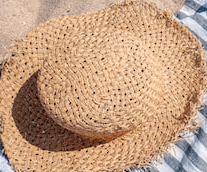

In [49]:
hat_query = [
    'a hat',
    'a photo of a hat',
    'a picture of a brown hat']

best_match(hat_query, candidates)

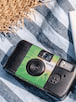

In [50]:
camera_query = [
    'a camera',
    'a little camera']
best_match(camera_query, candidates)

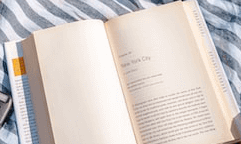

In [51]:
book_query = [
    'a book',
    'an open book']
best_match(book_query, candidates)

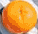

In [52]:
fruit_query = [
    'a fruit',
    'an orange fruit']
best_match(fruit_query, candidates)

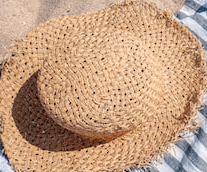

In [54]:
sunglasses_query = [
    'a sunglasses',
    'a small sunglasses']
best_match(sunglasses_query, candidates)

# failed because sunglasses is not in candidate regions

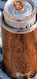

In [55]:
drink_query = [
    'a drink']
best_match(drink_query, candidates)